without electron
(2.1)
H2 <-> 2 H + 0 C + 0 O
CO <-> 0 H + 1 C + 1 O
CH4 <-> 4 H + 1 C + 0 O
H2O <-> 2 H + 0 C + 1 O

(2.2)
n_H2   = K_H2* x_H^2* x_C^0* x_O^0
n_CO   = K_CO*  x_H^0* x_C^1* x_O^1
n_CH4  = K_CH4* x_H^4* x_C^1* x_O^0 
n_H2O  = K_H2O* x_H^2* x_C^0* x_O^1 

(2.3)
ep_H xbH = xH + 4 n_CH4 + 2 n_H2O
ep_C xbH = xC + n_CO + n_CH4
ep_O xbH = xO + n_CO + n_H2O

In [2]:
import numpy as np
import jax.numpy as jnp
import jaxopt
from jax import jit

In [37]:
elem_=np.array(["H","C","O"])
spec_=np.array(["H2","CO","CH4","H2O"])

In [38]:
nu=np.array([[2,0,0],[0,1,1],[4,1,0],[2,0,1]]) #(2.1) formula matrix

In [39]:
@jit
def ni(x,nu,K):
    """law of mass action
    
    Returns:
        species number density
    """
    return K*jnp.prod(x**nu,axis=1)

In [40]:
#@jit
def en(x,nu,K):
    """(2.3)
    
    Returns:
        total element number density
    """
    return x+nu.T@ni(x,nu,K)

In [41]:
x0=np.array([0.1,0.2,0.3])
K=np.array([1,1,1,1])

In [42]:
np.shape(ni(x0,nu,K))

(4,)

In [43]:
enin=np.array([1.0,0.2,0.1])

In [44]:
en(x0,nu,K)

DeviceArray([0.12608   , 0.26002002, 0.36300004], dtype=float32)

In [45]:
def f(x):
    return np.sum((en(x,nu,K)-enin)**2)

In [46]:
gd = jaxopt.GradientDescent(fun=f, maxiter=500)

In [47]:
params, state = gd.run(init_params=np.random.rand(len(x0)))

In [48]:
xast=params

In [49]:
en(xast,nu,K)

DeviceArray([1.0004303 , 0.20002475, 0.10004018], dtype=float32)

In [50]:
enin

array([1. , 0.2, 0.1])

In [51]:
#from FastChem
#logK = a1/T + a2 ln T + a3 + a4 T + a5 T^2 for FastChem:
#H2 Hydrogen : H 2 # Chase, M. et al., JANAF thermochemical tables, 1998.
kpH2=[5.1909637142380554e+04,-1.8011701211306956e+00,8.7224583233705744e-02,2.5613890164973008e-04,-5.3540255367406060e-09]
#C1O1 Carbon_Monoxide : C 1 O 1 # Chase, M. et al., JANAF thermochemical tables, 1998.
kpCO=[1.2899777785630804e+05,-1.7549835812545211e+00,-3.1625806804795502e+00,4.1336204683783961e-04 ,-2.3579962985989574e-08] 
#C1H4 Methane : C 1 H 4 # Chase, M. et al., JANAF thermochemical tables, 1998.
kpCH4=[1.9784584536781305e+05,-8.8316803072239054e+00,5.2793066855988400e+00,2.7567674752936866e-03,-1.3966691995535711e-07]
#H2O1 Water : H 2 O 1 # Chase, M. et al., JANAF thermochemical tables, 1998.
kpH2O=[1.1033645388793820e+05,-4.1783597409582285e+00,3.1744691010633233e+00,9.4064684023068001e-04,-4.0482461482866891e-08]

In [52]:
A,B,C,D,E=jnp.array([kpH2,kpCO,kpCH4,kpH2O]).T

In [53]:
np.shape(A)

(4,)

In [54]:
#from functools import partial
#@partial(jit, static_argnums=(0,))

#
#  //adjusting log_K from its standard pressure (1 bar = 1e-6 dyn cm-2) to the actual pressure 
#  double_type pressure_scaling = 1.0e-6 * CONST_K * temperature;
#  mass_action_constant = log_K - sigma * std::log(pressure_scaling);
#
#constexpr double CONST_K = 1.3806504e-16;    //Boltzmann's constant in erg K-1
#double_type sigma = 0.0;

def logKa(T):
    return A/T+B*np.log(T) + C + D*T + E*T**2

In [55]:
logKa(1000.0)

array([ 39.8056  , 114.10198 , 144.73517 ,  85.548004], dtype=float32)

In [56]:
Tl=np.array([np.linspace(500,1500,800)]).T
Kl=(np.exp(logKa(Tl)))

In [57]:
import matplotlib.pyplot as plt

In [60]:
from exojax.atm.idealgas import number_density

In [74]:
T=400
Ka=np.exp(logKa(T))[0]
n=number_density(1.0,T)
print(n,"=",Ka,"*n_H^2")
n_H=np.sqrt(n/Ka)
print(n_H/n)

1.8107432585376616e+19 = 5.694099044350627e+51 *n_H^2
3.114290012357937e-36


6.11338853030786

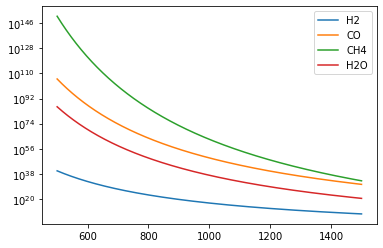

In [58]:
for i in range(0,4):
    plt.plot(Tl,Kl[:,i],label=spec_[i])
plt.legend()
plt.yscale("log")

In [59]:
#@jit
def logni(logx,nu,logK):
    """law of mass action
    
    Returns:
        species log number density
    """
    return logK+np.sum(nu*logx,axis=1)

In [36]:
ln=logni(jnp.log(x0),nu,logKl)
print(np.shape(ln))
import matplotlib.pyplot as plt
plt.plot(ln[:,0])
plt.plot(ln[:,1])
plt.plot(ln[:,2])
plt.plot(ln[:,3])

NameError: name 'logKl' is not defined

In [103]:
#@jit
def enx(logx,nu,logK):
    """(2.3)
    
    Returns:
        total element number density
    """
    return np.exp(logx)+nu.T@np.exp(logni(logx,nu,logK))

In [122]:
np.shape(np.exp(logni(np.log(x0),nu,logKa(1000.0))))

(4,)

In [123]:
eln= enx(np.log(x0),nu,logKa(1000.0))

In [124]:
eln

array([5.76467709e+58, 1.44116927e+58, 2.14789209e+48])